In [1]:
import gymnasium as gym
import aero_gym
from aero_gym.tools import evaluate, plotfile
import numpy as np
import math
from gymnasium.utils.env_checker import check_env
from gymnasium.wrappers import FrameStack, FlattenObservation
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
tmp_dir = '/u/home/b/beckers/project-sofia/tmp_dir/'

In [3]:
t_max = 20
delta_t = 0.1
t = np.linspace(0, t_max, int(t_max/delta_t)+1)

In [4]:
h_ddot_impulse = np.zeros(len(t))
h_ddot_impulse[0] = 1.0
h_ddot_ones = np.ones(len(t))
h_ddot_binary_periodic = (np.sin(t) > 0).astype(int) - 0.01*(np.sin(t) < 0).astype(int)

## Impulse

In [5]:
env = gym.make(
    'aero_gym/wagner-v0', 
    t_max=t_max, 
    delta_t=delta_t, 
    h_ddot_prescribed=h_ddot_impulse,
    observe_alpha_eff=True,
    reward_type=3)

`lift_upper_limit` and/or `lift_lower_limit` not provided, setting limits to plus and minus `lift_scale`


In [6]:
env.observation_space

Box(-inf, inf, (3,), float32)

In [7]:
env.reset()
env.step([0.0])

No reference lift provided, using zeros instead


(array([ 0. ,  0. , -0.1], dtype=float32),
 0.21460183660255172,
 False,
 False,
 {'previous scaled fy': -0.7853981633974483,
  'previous scaled fy_error': -0.7853981633974483,
  'previous scaled alpha_ddot': 0.0,
  'scaled alpha_dot': 0.0,
  'scaled alpha': 0.0,
  'scaled h_ddot': 1.0,
  'scaled h_dot': 0.1,
  'scaled reference_lift': 0.0,
  'previous fy': -0.7853981633974483,
  'previous fy_error': -0.7853981633974483,
  'previous alpha_ddot': 0.0,
  'alpha_dot': 0.0,
  'alpha': 0.0,
  'h_ddot': 1.0,
  'h_dot': 0.1,
  'reference_lift': 0.0,
  't': 0.1,
  'time_step': 1})

In [8]:
check_env(env.unwrapped)

No reference lift provided, using zeros instead
No reference lift provided, using zeros instead
No reference lift provided, using zeros instead
No reference lift provided, using zeros instead
No reference lift provided, using zeros instead
No reference lift provided, using zeros instead
`lift_upper_limit` and/or `lift_lower_limit` not provided, setting limits to plus and minus `lift_scale`
No reference lift provided, using zeros instead


/u/home/b/beckers/unsteady_aero_RL/gymnasium_28/env_gymnasium_28/lib/python3.9/site-packages/gymnasium/utils/env_checker.py:221: UserWarning: WARN: A Box observation space minimum value is -infinity. This is probably too low.
  logger.warn(
/u/home/b/beckers/unsteady_aero_RL/gymnasium_28/env_gymnasium_28/lib/python3.9/site-packages/gymnasium/utils/env_checker.py:225: UserWarning: WARN: A Box observation space maximum value is -infinity. This is probably too high.
  logger.warn(


In [9]:
obs, info, render_list = evaluate(env, tmp_dir + 'testlog_impulse.txt')

No reference lift provided, using zeros instead


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


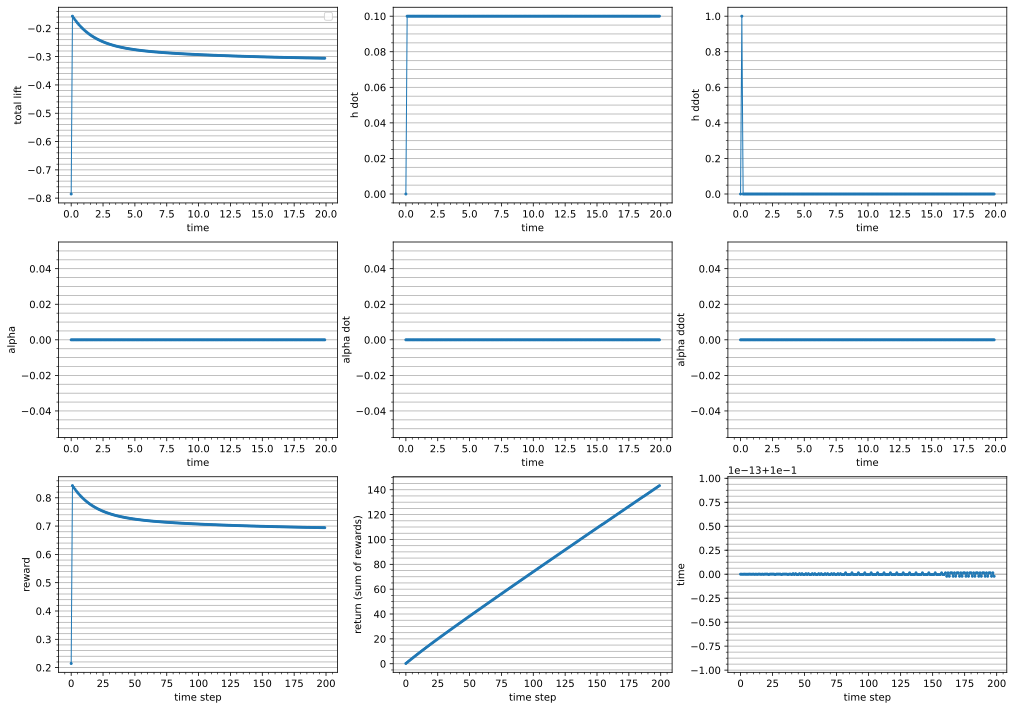

In [10]:
%config InlineBackend.figure_format = 'svg'
fig, axarr = plotfile(tmp_dir + 'testlog_impulse.txt')

## Step

In [11]:
env = gym.make(
    'aero_gym/wagner-v0', 
    render_mode="ansi", 
    t_max=t_max, 
    delta_t=delta_t, 
    h_ddot_prescribed=h_ddot_ones,
    reward_type=3,
    h_dot_termination=False,
    )

`lift_upper_limit` and/or `lift_lower_limit` not provided, setting limits to plus and minus `lift_scale`


In [12]:
obs, info, render_list = evaluate(env, tmp_dir + 'testlog_ones.txt')

No reference lift provided, using zeros instead


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


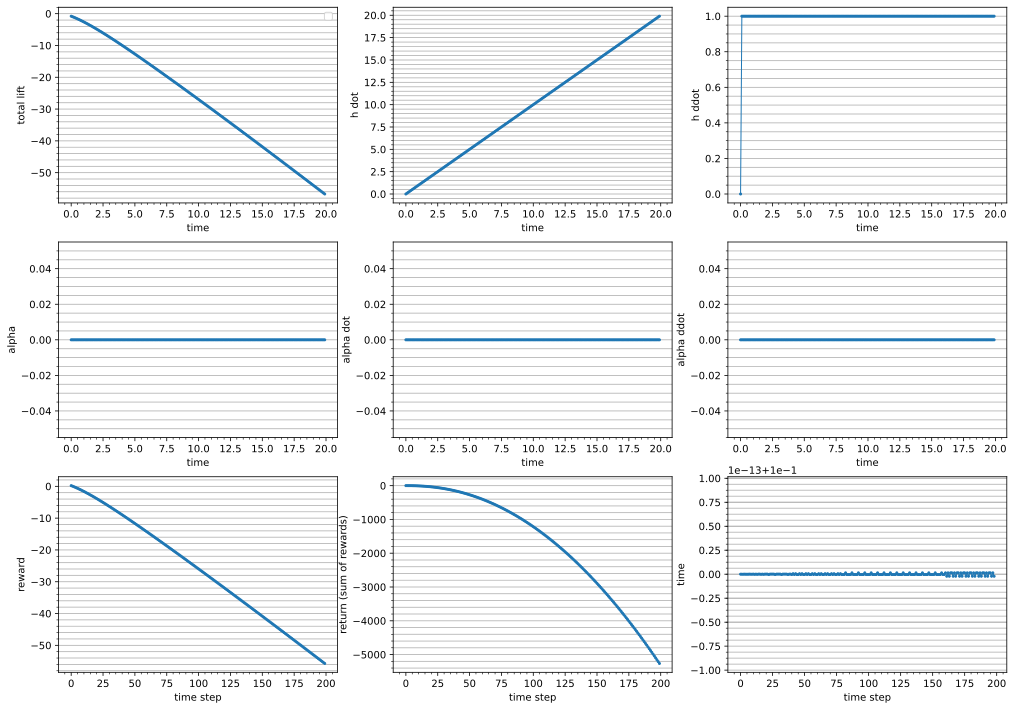

In [13]:
%config InlineBackend.figure_format = 'svg'
fig, axarr = plotfile(tmp_dir + 'testlog_ones.txt')

## Gaussian

In [14]:
def gaussian(x, a, b, c):
    return a * math.exp(-(x - b) ** 2 / (2 * c ** 2))

def dgaussian(x, a, b, c):
    return a * -(x - b) / c ** 2 * math.exp(-(x - b) ** 2 / (2 * c ** 2))

def ddgaussian(x, a, b, c):
    return a * (x ** 2 + b ** 2 - 2 * b * x - c ** 2) / c ** 4 * math.exp(-(x - b) ** 2 / (2 * c ** 2))

In [15]:
a = -2/3*0.1
b = 3.0
c = 0.4
h_ddot_dgaussian = [dgaussian(ti, a, b, c) for ti in t]

a = 0.015
b = 15.0
c = 0.4
alpha_ddot_ddgaussian = [ddgaussian(ti, a, b, c) for ti in t]

In [16]:
env = gym.make(
    'aero_gym/wagner-v0', 
    render_mode="ansi", 
    t_max=t_max, 
    delta_t=delta_t, 
    h_ddot_prescribed=h_ddot_dgaussian,
    reward_type=3,
    observe_alpha_eff=True,
    alpha_dot_termination=False,
    alpha_termination=False,
    h_dot_termination=False)

`lift_upper_limit` and/or `lift_lower_limit` not provided, setting limits to plus and minus `lift_scale`


In [17]:
obs, info, render_list = evaluate(env, tmp_dir + 'testlog_gaussian.txt', alpha_ddot_prescribed=alpha_ddot_ddgaussian)

No reference lift provided, using zeros instead


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


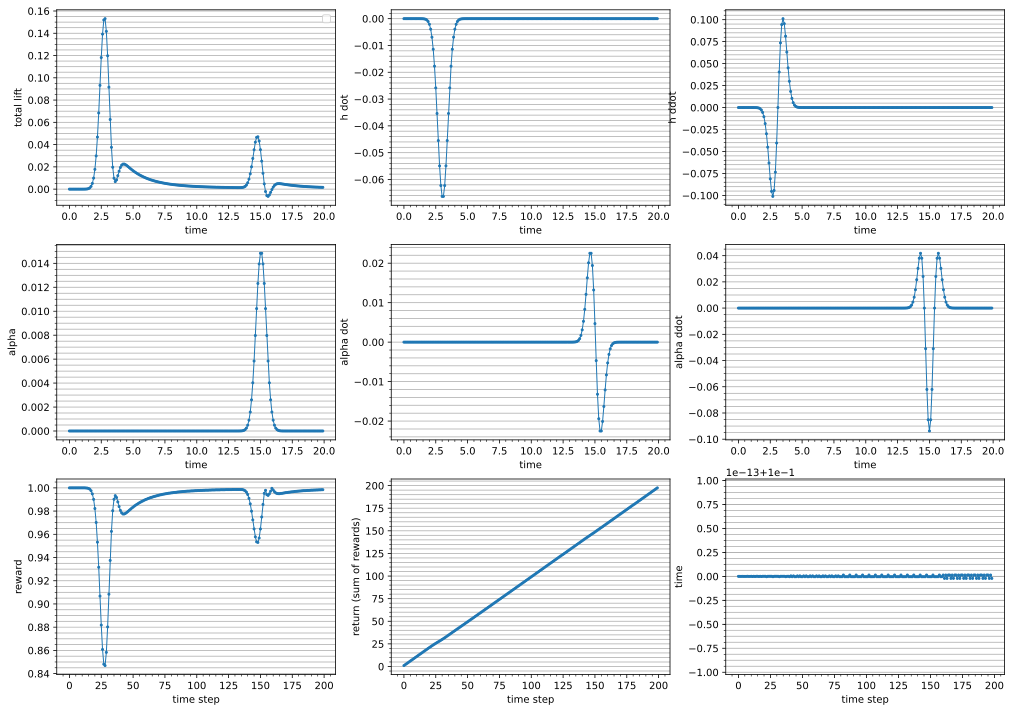

In [18]:
%config InlineBackend.figure_format = 'svg'
fig, axarr = plotfile(tmp_dir + 'testlog_gaussian.txt')

## Test h_ddot_generators

In [19]:
import sys
sys.path.append('../aero_gym_SB3/')
import trajectory_generators

In [20]:
env = gym.make(
    'aero_gym/wagner-v0', 
    render_mode="ansi", 
    t_max=t_max, 
    delta_t=delta_t, 
    reward_type=3,
    )

`lift_upper_limit` and/or `lift_lower_limit` not provided, setting limits to plus and minus `lift_scale`


In [43]:
h_ddot_generator_1 = trajectory_generators.random_d_steps_ramps(max_int_amplitude=0.1, max_d_amplitude=0.01)
h_ddot_generator_2 = trajectory_generators.random_fourier_series(max_amplitude=0.05, T=40, min_mode=5, max_mode=35, max_n_modes=30)
h_ddot_generator = trajectory_generators.random_mixed_events(h_ddot_generator_1, h_ddot_generator_2)

In [46]:
env.reset(options={"h_ddot_prescribed":None,"h_ddot_generator":h_ddot_generator_1})
obs, info, render_list = evaluate(env, tmp_dir + 'testlog_random.txt')

No reference lift provided, using zeros instead
No reference lift provided, using zeros instead


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


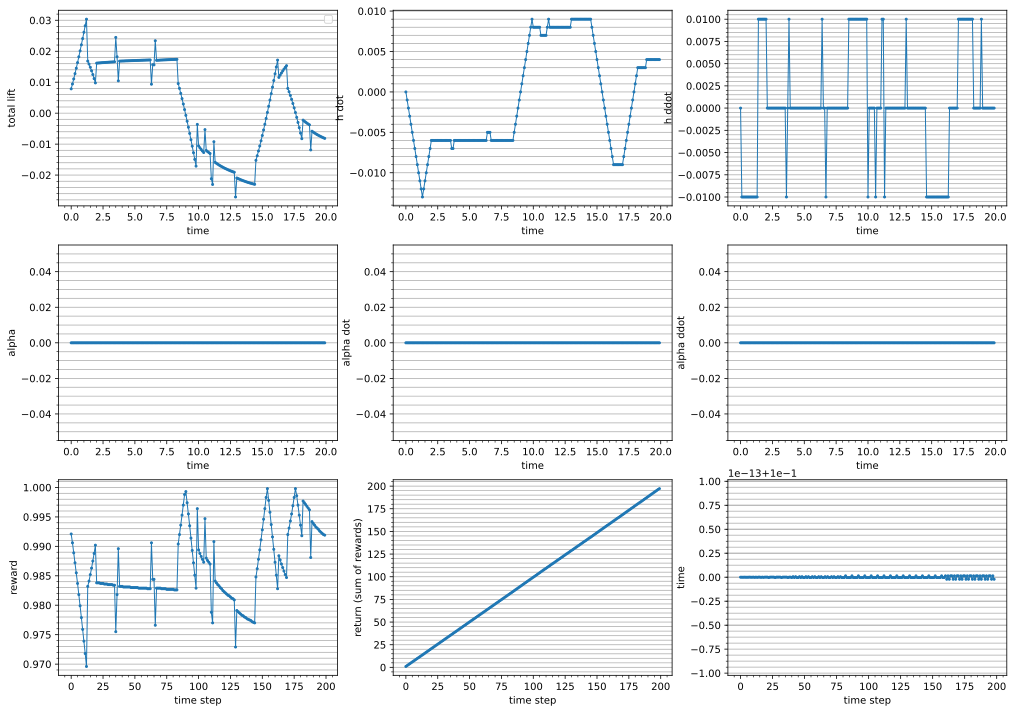

In [47]:
%config InlineBackend.figure_format = 'svg'
fig, axarr = plotfile(tmp_dir + 'testlog_random.txt')

No reference lift provided, using zeros instead


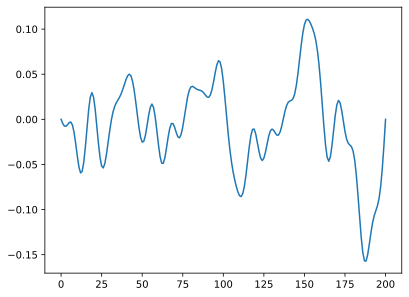

In [24]:
h_ddot_generator = trajectory_generators.random_fourier_series(max_amplitude=1 * 2 * math.pi / 40, T=40, min_mode=5, max_mode=40)
env.reset(options={"h_ddot_prescribed":None,"h_ddot_generator":h_ddot_generator})
plt.plot(env.h_ddot_list)